In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import os.path

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

Convert folder to dataframe of images' paths & labels

In [ ]:
def get_paths_labels(path, allowed_extension="jpg"):
        global Path
        images_dir = Path(path)
        
        filepaths = pd.Series((images_dir.glob(fr'**/*.{allowed_extension}'))).astype(str)
        filepaths.name = "path"
        
        labels = filepaths.str.split("/")[:].str[-2]
        labels.name = "label"

        
        df = pd.concat([filepaths, labels], axis=1)

        
        df = df.sample(frac=1).reset_index(drop = True)
        return df

# Read image
def get_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image
    
# Visualize samples
def visualize_samples(datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)
    
    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]
    images = filepaths.apply(get_image).reset_index(drop=True)
    
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(labels[sample_index])
            ax[i,j].set_axis_off()
    plt.show()
    

# Process image (input) for the model
def process(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    img = tf.keras.applications.mobilenet.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img


# Make classifications & visualize results
def visualize_classifications(model, datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)
    
    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]
    
    images = filepaths.apply(get_image).reset_index(drop=True)
    processed_images = np.vstack(images.apply(process).to_numpy()[:])
    
    y_pred = classes[np.argmax(model.predict(processed_images, verbose=0), axis=1)]
    y_true = labels
    
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    
    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(f"Y true({y_true[sample_index]}) | Y pred ({y_pred[sample_index]})")
            ax[i,j].set_axis_off()
    plt.show()

# Read datasets

In [ ]:
# Create dataframe of {paths, labels}
train_df = get_paths_labels('/content/drive/MyDrive/training')

# Import another dataset (to train model on various data)
temp_df = get_paths_labels('/content/drive/MyDrive/Sign Language/ASL Alphabet/asl_alphabet_test')

# Combine both datasets
dataset = pd.concat((train_df, temp_df))

In [ ]:
# Classes counts
print("Classes counts")
counts = dataset.iloc[:,1].value_counts().sort_index()
print(counts.head(counts.shape[0]))
print(f"\n\nDataset size = {counts.sum()} samples")

Classes counts
A                    1001
B                    1000
C                    1000
D                    1000
E                    1000
F                    1000
G                    1001
H                     981
I                     910
J                     900
K                     900
L                     990
M                     966
N                     965
O                     966
P                     966
Q                     966
R                     966
S                    1062
T                    1035
U                     967
V                     966
W                     966
X                     945
Y                     967
Z                     944
asl_alphabet_test      28
del                  1008
nothing               966
space                 965
Name: label, dtype: int64


Dataset size = 28297 samples


In [ ]:
# Preprocess data


train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    validation_split=0.2,
    horizontal_flip = True,
    brightness_range=(0.75, 1.3),
    zoom_range=0.2
)


train_images = train_generator.flow_from_dataframe(
    dataframe=dataset,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=dataset,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    subset='validation'
)

Found 22638 validated image filenames belonging to 30 classes.
Found 5659 validated image filenames belonging to 30 classes.


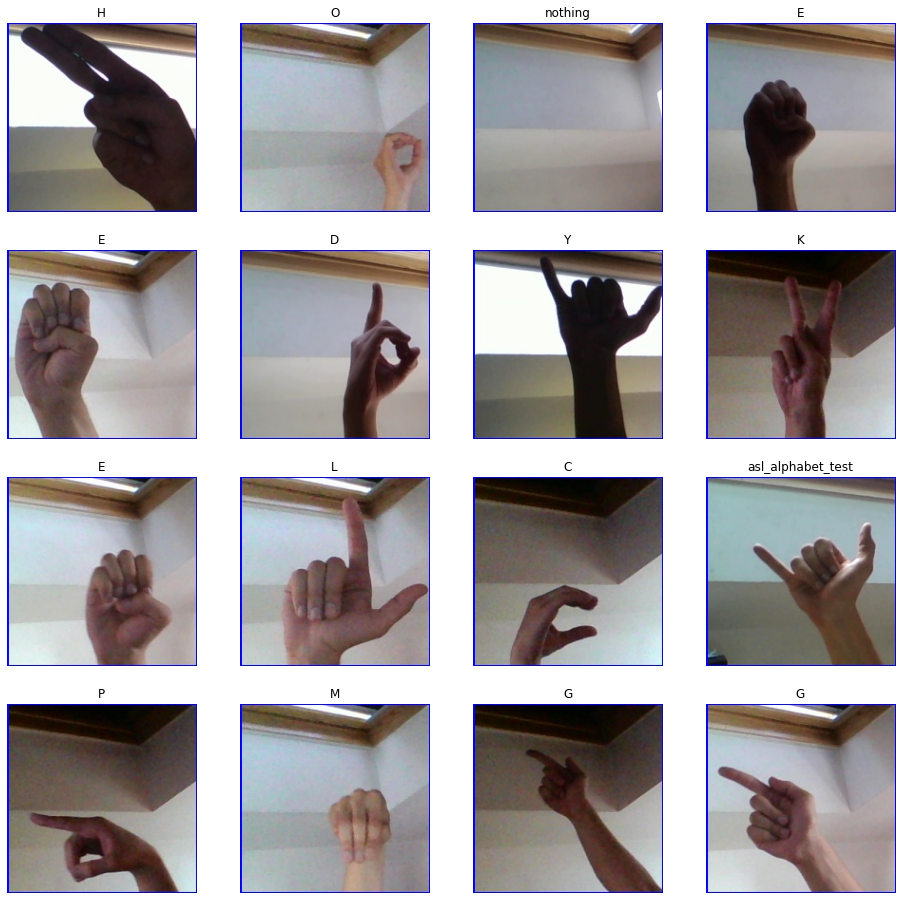

In [ ]:
visualize_samples(train_images)

In [ ]:
# Neural network architecture
pretrainedModel = tf.keras.applications.MobileNet(
    input_shape=(224, 224, 3),
     include_top=False,
     weights='imagenet',
     pooling='avg'
)
pretrainedModel.trainable = False

inputs = pretrainedModel.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrainedModel.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(30, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer_adam = tf.keras.optimizers.Adam(learning_rate = 0.005)

17225924/17225924 [==============================] - 1s 0us/step


In [ ]:
# Compile model

model.compile(
    optimizer=optimizer_adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Fit model
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=2
 )

Epoch 1/2
354/354 [==============================] - 13916s 39s/step - loss: 0.4787 - accuracy: 0.8548 - val_loss: 0.2138 - val_accuracy: 0.9251
Epoch 2/2
354/354 [==============================] - 397s 1s/step - loss: 0.1696 - accuracy: 0.9500 - val_loss: 0.1753 - val_accuracy: 0.9424


In [ ]:
model.save("/content/drive/MyDrive/sign_str2.h5")
# saving data model

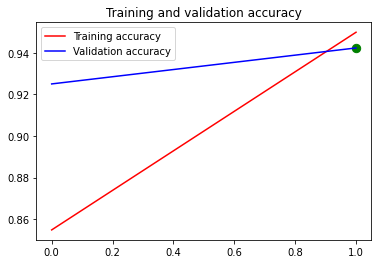

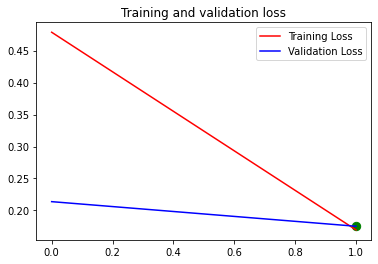

In [ ]:
%matplotlib inline
acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])
loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

epochs = np.arange(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.scatter(epochs[val_acc.argmax()], val_acc.max(), color='green', s=70)
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.scatter(epochs[val_loss.argmin()], val_loss.min(), color='green', s=70)
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **TESTING WITH MODEL**\

In [ ]:
from tensorflow import keras
model_path = "/content/drive/MyDrive/sign_str2.h5"
loaded_model = keras.models.load_model(model_path)

OSError: ignored

In [ ]:
class_label = {
    0:'A',
    1:'B',
    2:'C',
    3:'D',
    4:'E',
    5:'F',
    6:'G',
    7:'H',
    8:'I',
    9:'J',
    10:'K',
    11:'L',
    12:'M',
    13:'N',
    14:'O',
    15:'P',
    16:'Q',
    17:'R',
    18:'S',
    19:'T',
    20:'U',
    21:'V',
    22:'W',
    23:'X',
    24:'Y',
    25:'Z',
    26:'asl_alphabet_test',
    27:'del',
    28:'nothing',
    29:'space'
}

# print(class_label.items())

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
image = cv2.imread("/content/drive/MyDrive/testing/E1015.jpg")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((224, 224))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255
pred = loaded_model.predict(input_data)
result = pred.argmax()
result
print(result)

print("Sign Language is:",class_label[result])


1/1 [==============================] - 7s 7s/step
4
Sign Language is: E


 **interface**

In [ ]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.6 MB 32.0 MB/s 
     |████████████████████████████████| 106 kB 69.2 MB/s 
     |████████████████████████████████| 55 kB 5.1 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 56 kB 5.6 MB/s 
     |████████████████████████████████| 84 kB 4.7 MB/s 
     |████████████████████████████████| 213 kB 74.2 MB/s 
     |████████████████████████████████| 272 kB 62.8 MB/s 
     |████████████████████████████████| 2.3 MB 61.2 MB/s 
     |████████████████████████████████| 84 kB 4.4 MB/s 
     |████████████████████████████████| 64 kB 3.0 MB/s 
     |████████████████████████████████| 80 kB 12.1 MB/s 
     |████████████████████████████████| 68 kB 9.0 MB/s 
     |████████████████████████████████| 68 kB 5.4 MB/s 
     |████████████████████████████████| 68 kB 9.4 MB/s 
     |████████████████████████████████| 46 kB 5.7

In [ ]:
!pip install --upgrade fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gradio as gr

In [ ]:
import tensorflow as tf 
import numpy as np
import requests
import cv2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model

In [ ]:
class_label = {
    0:'A',
    1:'B',
    2:'C',
    3:'D',
    4:'E',
    5:'F',
    6:'G',
    7:'H',
    8:'I',
    9:'J',
    10:'K',
    11:'L',
    12:'M',
    13:'N',
    14:'O',
    15:'P',
    16:'Q',
    17:'R',
    18:'S',
    19:'T',
    20:'U',
    21:'V',
    22:'W',
    23:'X',
    24:'Y',
    25:'Z',
    26:'asl_alphabet_test',
    27:'del',
    28:'nothing',
    29:'space'
}

# print(class_label.items())

In [ ]:
model=tf.keras.models.load_model("/content/drive/MyDrive/sign_str2.h5")

In [ ]:
def predict_image(img):
  # img_3d=cv2.resize(img,(224,224))
  # img_3d=img.reshape(-1,224,224,3)
  # img_resize=img_3d
  # prediction=model.predict(img_resize)[0]

  
  image_fromarray = Image.fromarray(img, 'RGB')
  resize_image = image_fromarray.resize((224, 224))
  expand_input = np.expand_dims(resize_image,axis=0)
  input_data = np.array(expand_input)
  input_data = input_data/255
  prediction = loaded_model.predict(input_data)
  res = pred.argmax()

  # print(prediction)
  res = prediction.argmax()
  print(res)
  print("Sign Language is:",class_label[res])
  return (class_label[res])

In [ ]:
image_1=gr.inputs.Image(shape=(224,224))
print(image_1)
label=gr.outputs.Label(num_top_classes=30)

gr.Interface(fn=predict_image, inputs=image_1, outputs='label',interpretation='default').launch(debug='True')

/usr/local/lib/python3.7/dist-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  "Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
 

image
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 22ms/step
20
Sign Language is: U
